- File: Calculate 3 quantization metrics
- Author: Haotian Li
- Desc: This file is to calculate 3 quantization metrics

In [5]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from matplotlib import pyplot as plt
import glob
from model import PTModel
import numpy as np
from PIL import Image
import matplotlib as mpl
import cv2
import os
from tqdm import tqdm
import csv

In [2]:
def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

In [3]:
def my_DepthNorm(x, maxDepth):
    return maxDepth / x

def my_predict(model, images, minDepth=0, maxDepth=255):

  with torch.no_grad():
    # Compute predictions
    predictions = model(images)

    # Put in expected range
  return np.clip(my_DepthNorm(predictions.numpy(), maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

In [9]:
model = torch.load('./epoch-raw/model-epoch19.pth',map_location=torch.device('cpu'))

In [10]:
testnamelist = []

with open('./data/nyu2_test.csv') as file:
    read_obj = csv.reader(file)
    for row in read_obj:
        # print(row)
        testnamelist.append(row)

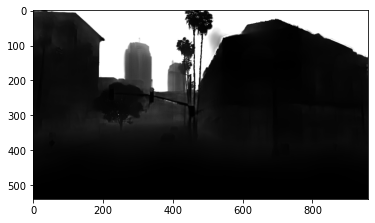

In [6]:
# test and Display
for i in range(1):
    savepath = './data/prediction/' + str(i+1) + '.png'
    img = load_images(glob.glob(savepath)).astype('float32')[0]
    # print(np.max(img),np.min(img))
    plt.figure()
    plt.imshow(img,cmap='gray')

In [11]:
for i in tqdm(range(len(testnamelist))):
    savepath = './data/prediction/' + str(i+1) + '.png'
    if (os.path.exists(savepath)):
        continue
    imgname = testnamelist[i][0]
    img = load_images(glob.glob(imgname)).astype('float32')
    tensor_input = torch.from_numpy(img[0,:,:,:]).permute(2,0,1).unsqueeze(0)
    output = my_predict(model,tensor_input[0,:,:,:].unsqueeze(0))
    output = output[0,0,:,:]
    output = (output-np.min(output))/(np.max(output)-np.min(output))*255
    
    # print(np.max(output),np.min(output))
    cv2.imwrite(savepath, output)

100%|██████████| 654/654 [27:18<00:00,  2.51s/it]


***Computer MSE & absRel***

In [14]:
# Our model
N = len(testnamelist) * 320 * 240
sqrError = 0
sumRel = 0
for i in tqdm(range(len(testnamelist))):
    depthname = testnamelist[i][1]
    depthimg = load_images(glob.glob(depthname)).astype('float32')
    depthimg = cv2.resize(depthimg[0],(320,240)) # half og the origin image
    predname = './data/prediction/' + str(i+1) + '.png'
    predimg = load_images(glob.glob(predname)).astype('float32')

    error = depthimg - predimg
    sqrError += np.sum(error**2)
    sumRel += np.sum((np.abs(error)+0.001)/(depthimg+0.001))

mse = (sqrError/N)**(1/2)
absrel = sumRel/N
print("mse: ",mse)
print("absrel: ",absrel)


100%|██████████| 654/654 [00:14<00:00, 45.21it/s]

mse:  0.6325625342754342
absrel:  0.5784726154354612


***Compurte Accuracy***

In [15]:
# Our model
N = len(testnamelist) * 320 * 240
threshold = 1.25**2
acc_pixels = 0
for i in tqdm(range(len(testnamelist))):
    depthname = testnamelist[i][1]
    depthimg = load_images(glob.glob(depthname)).astype('float32')
    depthimg = cv2.resize(depthimg[0],(320,240))
    predname = './data/prediction/' + str(i+1) + '.png'
    predimg = load_images(glob.glob(predname)).astype('float32')
    
    acc_n = np.array(((depthimg+0.001)/(predimg+0.001),(predimg+0.001)/(depthimg+0.001)))
    acc = acc_n.max(axis=0)
    acc = (acc < threshold).astype('float')
    acc_pixels += np.sum(acc)

acc = acc_pixels / N
print("acc: ",acc)

100%|██████████| 654/654 [00:13<00:00, 48.60it/s]

acc:  0.24529796604230378
